In [1]:
import theano
import numpy

from theano import tensor

theano.config.floatX = 'float32'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 4007)
/u/georgeth/.conda/envs/testenv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load model and parameters from vggnet 19

In [2]:
import lasagne
import pickle

from vggnet import build_model
vggnet_model = build_model()

params_val = pickle.load(open('./vgg19.pkl'))
lasagne.layers.set_all_param_values(vggnet_model['pool5'], params_val['param values'][:32])

## Build the network for texture generation

In [3]:
X = tensor.ftensor4('image')

Z_names = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5']
Zs = dict()
for i in range(5):
    Zs['Z%d' % (i+1,)] = tensor.ftensor4('Z%d' % (i+1,))

In [4]:
from tg_model_bricks import build_model

generated_image_graph = build_model(Zs)

In [5]:
f_texture_generation = theano.function([Zs[n] for n in Z_names], [generated_image_graph])

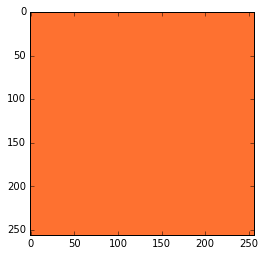

In [6]:
# test texture generation net
theano.config.exception_verbosity = 'low'

def generate_noisy_images(n=1):
    Z1 = numpy.random.rand(n, 1, 256, 256).astype('float32')
    Z2 = numpy.random.rand(n, 1, 128, 128).astype('float32')
    Z3 = numpy.random.rand(n, 1, 64, 64).astype('float32')
    Z4 = numpy.random.rand(n, 1, 32, 32).astype('float32')
    Z5 = numpy.random.rand(n, 1, 16, 16).astype('float32')
    
    return Z1, Z2, Z3, Z4, Z5

Z1, Z2, Z3, Z4, Z5 = generate_noisy_images()

o = f_texture_generation(Z1, Z2, Z3, Z4, Z5)
plt.imshow(numpy.rollaxis(o[0][0], 0, 3)/numpy.max(o[0][0]))

## Load an image

0 255


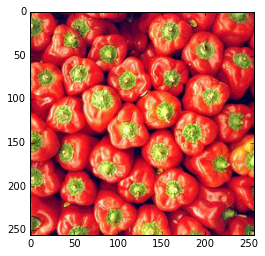

In [7]:
texture_image = mpimg.imread('./red-peppers256.jpg')
plt.imshow(texture_image)

print texture_image.min(), texture_image.max()

## Define Gram matrix

In [8]:
def gram_matrix(X):
    X = X.flatten(ndim=3)
    return tensor.batched_tensordot(X, X, axes=[[2],[2]])

## Compute texture features for target image

In [9]:
texture_loss_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

def texture_features(X):
    layers = [vggnet_model[k] for k in texture_loss_layers]
    outputs = lasagne.layers.get_output(layers, X)
    
    return outputs

In [10]:
MEAN_VALUES = numpy.array([104, 117, 123]).reshape((3,1,1))


texture_image_nn_input = numpy.rollaxis(texture_image, 2)[None]
# Convert RGB to BGR
texture_image_nn_input = texture_image_nn_input[::-1, :, :]-MEAN_VALUES
texture_image_nn_input = texture_image_nn_input.astype('float32')

# print texture_image_nn_input
print texture_image_nn_input.shape

f_features_gram = theano.function(
        inputs=[X],
        outputs=[gram_matrix(f) for f in texture_features(X)]
)
target_image_features = f_features_gram(texture_image_nn_input)
# print target_image_features
print [t.shape for t in target_image_features]

f_features = theano.function(
        inputs=[X],
        outputs=texture_features(X)
)
target_image_ff = f_features(texture_image_nn_input)
# print target_image_features
print [t.shape for t in target_image_ff]

(1, 3, 256, 256)
[(1, 64, 64), (1, 128, 128), (1, 256, 256), (1, 512, 512), (1, 512, 512)]
[(1, 64, 256, 256), (1, 128, 128, 128), (1, 256, 64, 64), (1, 512, 32, 32), (1, 512, 16, 16)]


## Define loss function

In [11]:
from blocks.graph import ComputationGraph, apply_batch_normalization, get_batch_normalization_updates

cg = ComputationGraph(generated_image_graph)
cg_bn = apply_batch_normalization(cg)
pop_updates = get_batch_normalization_updates(cg_bn)

In [12]:
text_generated = texture_features(cg.outputs[0])
gram_generated = [gram_matrix(f) for f in text_generated]

loss = 0
for i in range(len(target_image_features)):
    N = text_generated[i].shape[1]
    M = text_generated[i].shape[2]*text_generated[i].shape[3]
    loss += 1./ (4 * 16 * N ** 2 * M ** 2) * ((gram_generated[i]
        - tensor.addbroadcast(theano.shared(target_image_features[i]), 0)) ** 2).sum()

In [13]:
f_loss = theano.function([Zs[n] for n in Z_names], [loss])

In [14]:
Z1, Z2, Z3, Z4, Z5 = generate_noisy_images(5)

o = f_loss(Z1, Z2, Z3, Z4, Z5)

print o

[array(246115989782.5)]


In [15]:
# shapes
i=3
f_shapes = theano.function([Zs[n] for n in Z_names], [gram_generated[i].shape])
print f_shapes(Z1, Z2, Z3, Z4, Z5)
print target_image_features[i].shape

[array([  5, 512, 512])]
(1, 512, 512)


In [16]:
# shapes
i=3
f_shapes = theano.function([Zs[n] for n in Z_names], [text_generated[i].shape])
print f_shapes(Z1, Z2, Z3, Z4, Z5)
print target_image_features[i].shape

[array([  5, 512,  32,  32])]
(1, 512, 512)


## Learn weights

In [17]:
alpha = 0.1
extra_updates = [(p, m * alpha + p * (1 - alpha))
    for p, m in pop_updates]

In [18]:
from fuel.datasets import Dataset

class RandomImagesDataset(Dataset):
    
    def __init__(self, sources=None):
        self.provides_sources = ('Z1', 'Z2', 'Z3', 'Z4', 'Z5')
        if sources == None:
            sources = self.provides_sources
        super(RandomImagesDataset, self).__init__(sources=sources)
        
    def get_data(self, state, request):
        n = len(request)
        Z1 = numpy.random.rand(n, 1, 256, 256).astype('float32')*2-1
        Z2 = numpy.random.rand(n, 1, 128, 128).astype('float32')*2-1
        Z3 = numpy.random.rand(n, 1, 64, 64).astype('float32')*2-1
        Z4 = numpy.random.rand(n, 1, 32, 32).astype('float32')*2-1
        Z5 = numpy.random.rand(n, 1, 16, 16).astype('float32')*2-1
        
        return [Z1, Z2, Z3, Z4, Z5]

In [19]:
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme

ds = RandomImagesDataset()
train_stream = DataStream.default_stream(
    ds,
    iteration_scheme=SequentialScheme(160, 16)
)

In [20]:
from blocks.algorithms import GradientDescent, Adam, Scale, Momentum

algorithm = GradientDescent(cost=loss, parameters=cg.parameters,
    step_rule=Adam(1e-3))
algorithm.add_updates(extra_updates)


In [21]:
# algorithm.step_rule.learning_rate.set_value(1e-1)

# main_loop.algorithm.step_rule = Adam(1e-2)

In [22]:
from blocks.extensions import Printing, Timing
from blocks.extensions.training import TrackTheBest
from blocks.extensions.monitoring import TrainingDataMonitoring
from blocks.extensions.stopping import FinishIfNoImprovementAfter
from blocks_extras.extensions.plot import Plot
import datetime

loss.name = 'loss'

extensions = [
    Timing(),
    TrainingDataMonitoring([loss], after_epoch=True),
    Plot('FF text gen %s' % (datetime.datetime.now(), ),
         channels=[['loss']], after_epoch=True),
    TrackTheBest('loss'),
    FinishIfNoImprovementAfter('loss_best_so_far', epochs=5),
    Printing()
]

Using saved session configuration for http://localhost:5006/
To override, pass 'load_from_config=False' to Session


In [23]:
from blocks.main_loop import MainLoop


main_loop = MainLoop(data_stream=train_stream, algorithm=algorithm,
                     extensions=extensions)


In [24]:
def print_img():
    Z1, Z2, Z3, Z4, Z5 = generate_noisy_images(16)

    rgb = -1

    o = f_texture_generation(Z1, Z2, Z3, Z4, Z5)
    plt.imshow(numpy.rollaxis(o[0][0]+MEAN_VALUES, 0, 3)[::rgb,:,:].astype('int32'))
    plt.show()
    plt.imshow(numpy.rollaxis(o[0][1]+MEAN_VALUES, 0, 3)[::rgb,:,:].astype('int32'))
    plt.show()

In [25]:
main_loop.run()


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 time_initialization: 130.691319942


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 best_loss: 6.64429099139e+11
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 10
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 10:
	 loss: 6.64429099139e+11
	 loss_best_so_far: True
	 loss_

In [26]:
# reinit adam
# main_loop.algorithm.step_rule = Adam(1e-1)

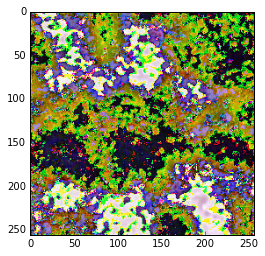

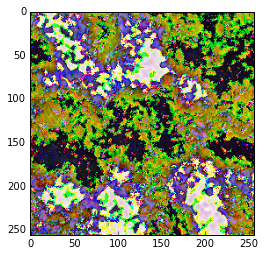

===
(0) Learning rate set to 3.000000e-04
===

-------------------------------------------------------------------------------
TRAINING HAS BEEN RESUMED
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 best_loss: 2.2753882475e+11
	 epoch_interrupt_received: True
	 epoch_started: False
	 epochs_done: 14
	 iterations_done: 140
	 received_first_batch: True
	 resumed_from: db1bb1c1d75b4015a3f61e6b750e30ba
	 training_started: True
Log records from the iteration 140:
	 loss: 2.2753882475e+11
	 loss_best_so_far: True
	 loss_best_so_far_patience_epochs: 5
	 time_read_data_this_epoch: 0.247250795364
	 time_read_data_total: 3.45029640198
	 time_train_this_epoch: 21.7389979362
	 time_train_total: 302.35409379
	 training_finished: True


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------


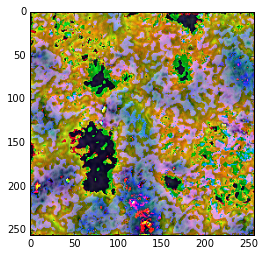

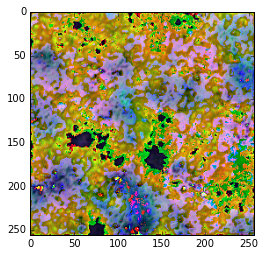

===
(1) Learning rate set to 9.000000e-05
===

-------------------------------------------------------------------------------
TRAINING HAS BEEN RESUMED
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 best_loss: 1.1349438043e+11
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 29
	 iterations_done: 290
	 received_first_batch: True
	 resumed_from: 3b24e17f9b69465f893ce570fa7b3982
	 training_started: True
Log records from the iteration 290:
	 loss: 1.24335589119e+11
	 loss_best_so_far_patience_epochs: 0
	 time_read_data_this_epoch: 0.246411800385
	 time_read_data_total: 7.15625452995
	 time_train_this_epoch: 22.0577127934
	 time_train_total: 632.824568272
	 training_finish_requested: True
	 training_finished: True


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
--------------------------------------------------------------------

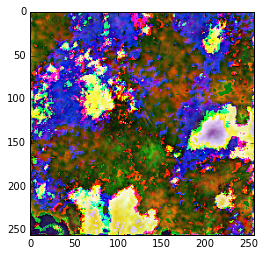

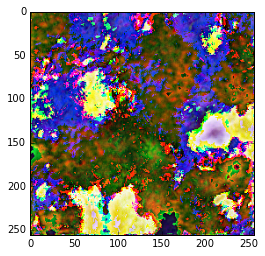

===
(2) Learning rate set to 2.700000e-05
===

-------------------------------------------------------------------------------
TRAINING HAS BEEN RESUMED
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 best_loss: 99716942771.2
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 43
	 iterations_done: 430
	 received_first_batch: True
	 resumed_from: 56c0041e75894f68b2e4765e373be142
	 training_started: True
Log records from the iteration 430:
	 loss: 1.16501489311e+11
	 loss_best_so_far_patience_epochs: 0
	 time_read_data_this_epoch: 0.243633747101
	 time_read_data_total: 10.5804932117
	 time_train_this_epoch: 22.0093388557
	 time_train_total: 941.741623878
	 training_finish_requested: True
	 training_finished: True


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-----------------------------------------------------------------------

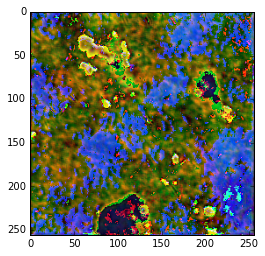

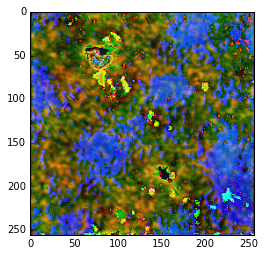

===
(3) Learning rate set to 8.100000e-06
===

-------------------------------------------------------------------------------
TRAINING HAS BEEN RESUMED
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 best_loss: 69519090664.0
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 60
	 iterations_done: 600
	 received_first_batch: True
	 resumed_from: 8a8f7041012f4914a62f72984728fb4f
	 training_started: True
Log records from the iteration 600:
	 loss: 72505396002.5
	 loss_best_so_far_patience_epochs: 0
	 time_read_data_this_epoch: 0.244193553925
	 time_read_data_total: 14.7282958031
	 time_train_this_epoch: 21.9531464577
	 time_train_total: 1315.94417787
	 training_finish_requested: True
	 training_finished: True


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
---------------------------------------------------------------------------

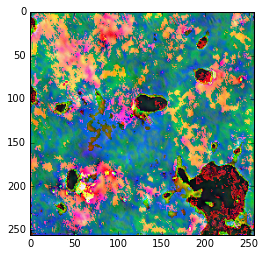

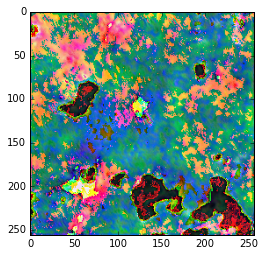

===
(4) Learning rate set to 2.430000e-06
===

-------------------------------------------------------------------------------
TRAINING HAS BEEN RESUMED
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 best_loss: 54511052244.7
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 75
	 iterations_done: 750
	 received_first_batch: True
	 resumed_from: 0b759701039241acb988be5bbde0a5a5
	 training_started: True
Log records from the iteration 750:
	 loss: 62277448673.5
	 loss_best_so_far_patience_epochs: 0
	 time_read_data_this_epoch: 0.237366199493
	 time_read_data_total: 18.3404269218
	 time_train_this_epoch: 21.9774136543
	 time_train_total: 1645.70836782
	 training_finish_requested: True
	 training_finished: True


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
---------------------------------------------------------------------------

In [27]:
for i in range(5):
    
    print_img()
    new_lr = 0.3*algorithm.step_rule.learning_rate.get_value()
    print '===\n(%d) Learning rate set to %e\n===' % (i, new_lr)
    
    # 
    #algorithm.step_rule.learning_rate.set_value(
    #    numpy.float32(new_lr))
    main_loop.algorithm.step_rule = Adam(new_lr)
    
    # reinit early stopping
    extensions[4].last_best_iter = main_loop.log.status['iterations_done']
    extensions[4].last_best_epoch = main_loop.log.status['epochs_done']

    main_loop.run()

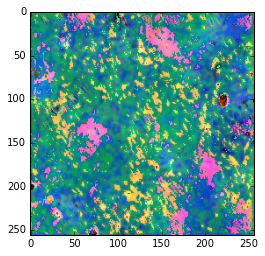

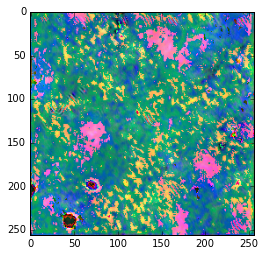

In [28]:
print_img()

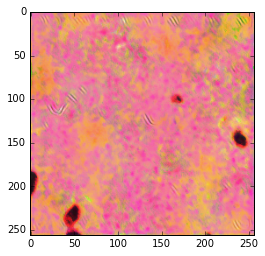

-191.267
170.005
274.005432129
-74.2669525146


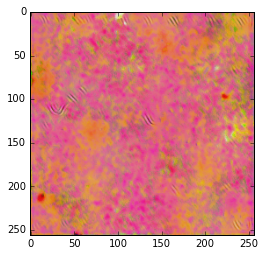

In [29]:
Z1, Z2, Z3, Z4, Z5 = generate_noisy_images(16)

rgb = -1

o = f_texture_generation(Z1, Z2, Z3, Z4, Z5)

plt.imshow((numpy.rollaxis(o[0][0], 0, 3)[::rgb,:,:]
            -numpy.min(o[0][0]))/(numpy.max(o[0][0])-numpy.min(o[0][0])))
plt.show()
plt.imshow((numpy.rollaxis(o[0][1], 0, 3)[::rgb,:,:]
            -numpy.min(o[0][1]))/(numpy.max(o[0][1])-numpy.min(o[0][1])))

print numpy.min(o[0][0])
print numpy.max(o[0][0])

print numpy.max(o[0][0]+MEAN_VALUES)
print numpy.min(o[0][0]+MEAN_VALUES)


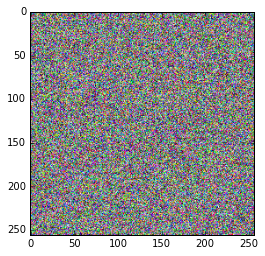

In [30]:
plt.imshow(numpy.rollaxis(o[0][0], 0, 3)+texture_image.mean())
